In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Dataset koji je korišten u ovome radu preuzet može se pronaći na stranici [url](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) ili se čak izravno importati iz scikit-learn biblioteke pomoću `sklearn.datasets.load_breast_cancer`.
Kreiran je u radu *W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.* za praktičnu primjenu strojnog učenja u sveučilišnim bolnicama *University of Wisconsin Hospitals*.

1. Ovo istraživanje spada u sljedeće kategorije:
    1. Prema svrsi je teoretsko jer je fokusirano na generiranju znanja.
    2. Prema izvoru informacija je sekundarno je koristi druge znanstvene radove kao izvore podataka.
    3. Prema vremenu provedbe je sinkrono jer promatra podatke u trenutku kada je dataset nastao.
    4. Prema načinu prikupljanja je dokumentarno istraživanje jer koristi postojeće skupove podataka.
    5. Prema vrsti korištenih podataka je kvantitativno jer se koriste matematički, statistički i računalni alati za mjerenje fenoemna nad podacima.
    6. Prema stupnju manipulacije varijablama je promatračko jer rad ne upravlja podacima samo modelima koji se korise nad njime.
    7. Prema dubini je korelacijsko jer se grade modeli koji usporeduju atribute skupa podataka sa činjenicom je li ti podaci pripadaju tkivu koje ima rak ili ne.
    8. Prema vrsti zaključka je deduktivno jer se donose zaključci o generiranim modelima.
2. Podaci za ovaj dataset prikupljeni su analizom slika stanica iz tkiva dojke. Slike su kreirane tako da se uzme mala količina tekućine iz tumora dojke sa malom iglom. Taj se materijal stavi na komad stakla i uslika sa JVC TK-1070U video kamerom u boji na Olympus mikroskopu sa 63x objektivom i 2.5x okularom. Zatim se računalom slika pohrani u 8-bitni file veličine 512x418 pixela. Nad tom slikom se traži rub stanice i pomoću posebno napravljenih alata generiraju atributi za dataset.
3. Dataset je kreiran analizom 569 slika stanica i njihovom analizom u obliku izlučivanja statističkih značajki tih stanica. Slike su prikupljenje u skopu sveučilišne bolnice, a doktori koji su ih objavili prisegnuli su Hipokratovu zakletvu. Stoga smatram da su podaci etički prikupljeni. Za ostale aspekte istraživačke etike nema izvora koje bi mogao citirati za metode prikupljanja slika za ovaj dataset.


In [60]:
X = pd.read_csv('./dataset/data.csv')
X.shape

(569, 32)

In [61]:
X['diagnosis'] = X['diagnosis'].map({'B': 0, 'M': 1})

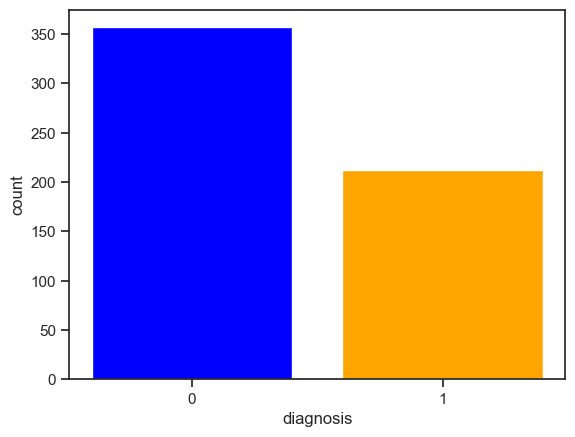

In [62]:
count_per_diagnosis = X.groupby('diagnosis').count().loc[:, 'id'].values
title_names = X.groupby('diagnosis').count().index.array

plt.figure()
plt.bar(np.vectorize(lambda x: str(x))(title_names), count_per_diagnosis, color=['blue', 'orange'])
plt.xlabel('diagnosis')
plt.ylabel('count')
plt.show()

Vrlo, vrlo neupotrebljiv graf koji ništa ne predstavlja.

C:\ProgramData\Anaconda3\envs\DataScienceProject\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


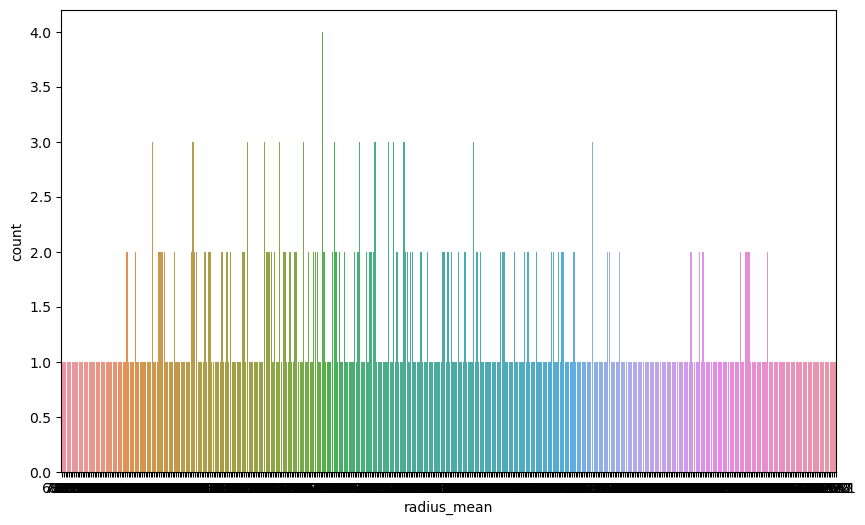

In [63]:
#Reset theme to default
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

plt.figure(figsize=(10, 6))
sns.countplot(X['radius_mean'])

plt.xlabel('radius_mean')
plt.ylabel('count')
plt.show()

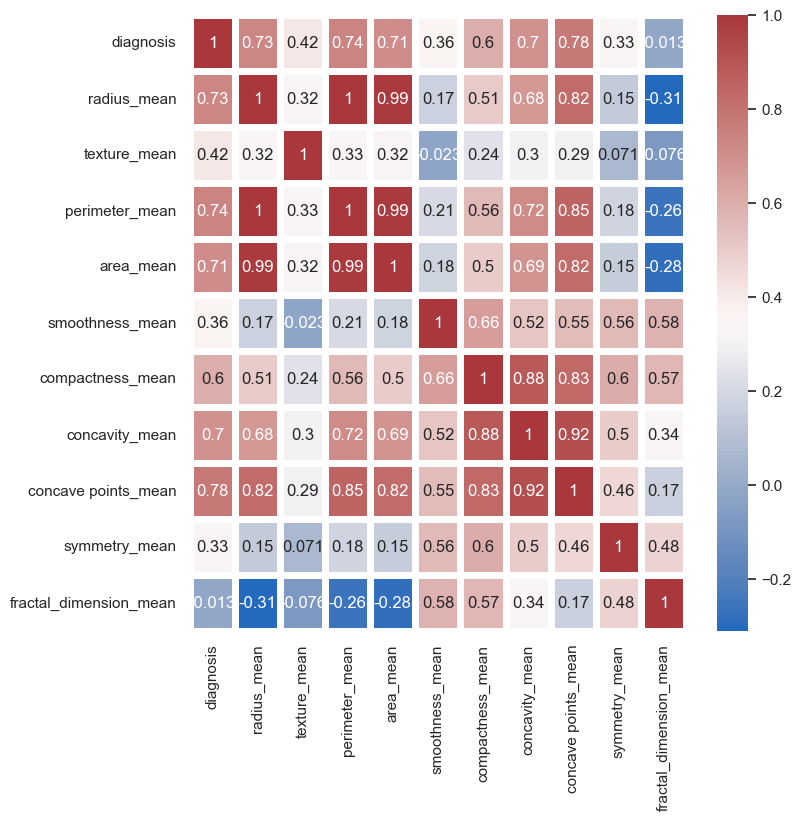

In [64]:
sns.set_theme(style='white')

corr_columns = [col for col in X if col.endswith('mean') or col.startswith('diagnosis')]
corr = X[corr_columns].corr()

plt.subplots(figsize=(8, 8))
sns.heatmap(corr, linewidths=5, annot=True, cmap='vlag')

plt.show()

Ostavljen je id u grafu...

C:\ProgramData\Anaconda3\envs\DataScienceProject\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


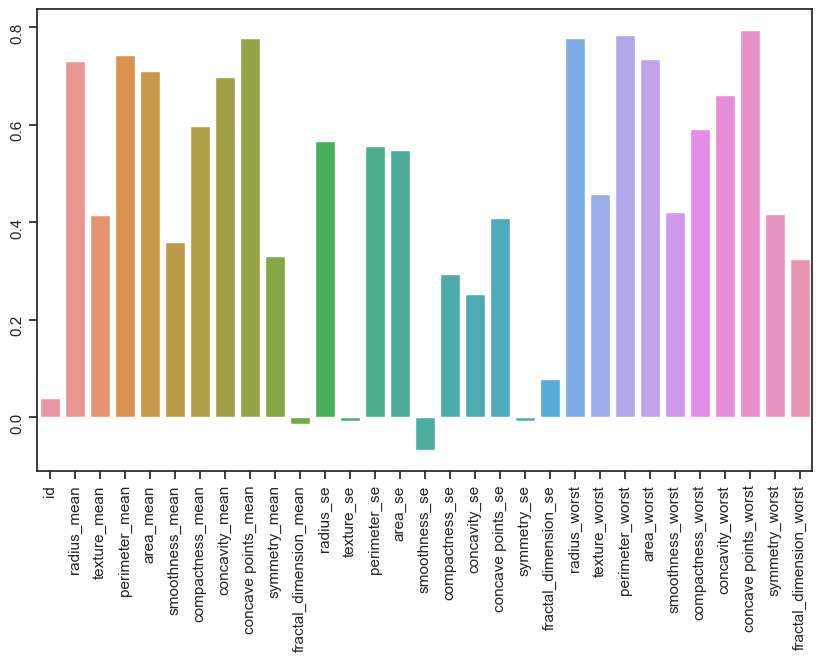

In [65]:
sns.set_style("ticks")

corr_with_target = X.corr()['diagnosis'].drop(labels=['diagnosis'])

plt.figure(figsize=(10, 6))
g = sns.barplot(corr_with_target.index, corr_with_target.values)
g.tick_params(axis='x', rotation=90)
g.tick_params(axis='y', rotation=90)
plt.show()

U tekstu nije navedeno koji se atributi uklanjaju kod feature selectiona.

Dalje uklanjam id, fractal_dimension_mean, texture_se, smoothness_sem symetry_se i fractal_dimension_se

Također skup podataka se dijeli na train i test skupove. Ta se podjela radi nasumično i zadaje se samo omjer.
Ovisno o tom nasumičnom odabiru svi će modeli biti trenirani i testirani na podskupu cijelog skupa podataka koji se razlikuje od onog upotrebljenog u paperu. To znači da modeli neće moći imati identične accuray_score rezultate već će imati približne-


In [66]:
X_trimmed = X.drop(columns=['id', 'fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se',
                            'fractal_dimension_se'])

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X_trimmed.drop(columns=['diagnosis']), X['diagnosis'],
                                                    test_size=0.25)


def test_model(model, model_label, mod=None):
    if mod is not None:
        train_accuracy = accuracy_score(y_train, model.predict(mod.fit_transform(X_train)))
        test_accuracy = accuracy_score(y_test, model.predict(mod.fit_transform(X_test)))
    else:
        train_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_accuracy = accuracy_score(y_test, model.predict(X_test))

    print('Algorith {}: Training accuracy={}, Testing accuracy={}\n'.format(model_label, train_accuracy, test_accuracy))

    return {'Algorithms': model_label, 'Training Accuracy': "{:.2%}".format(train_accuracy),
            'Testing Accuracy': "{:.2%}".format(test_accuracy)}


def draw_confusion_matrix(model, graph_label, mod=None):
    if mod is None:
        y_generated = model.predict(X_test)
    else:
        y_generated = model.predict(mod.fit_transform(X_test))

    cf_matrix = confusion_matrix(y_test, y_generated)

    sns.heatmap(cf_matrix, annot=True, cmap='Blues', linewidths=5)
    plt.title(graph_label)
    plt.show()

In [68]:
results = pd.DataFrame(columns=['Algorithms', 'Training Accuracy', 'Testing Accuracy'])


In [69]:
from sklearn.linear_model import LogisticRegression

poly = PolynomialFeatures(2).fit(X_train)

log_reg = LogisticRegression(max_iter=5000).fit(poly.transform(X_train), y_train)

results = results.append(test_model(log_reg, 'Logistic regression', poly), ignore_index=True)

Algorith Logistic regression: Training accuracy=0.9929577464788732, Testing accuracy=0.9300699300699301



C:\ProgramData\Anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5).fit(X_train, y_train)

results = results.append(test_model(knn, 'KNN'), ignore_index=True)


Algorith KNN: Training accuracy=0.9530516431924883, Testing accuracy=0.9090909090909091



In [71]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini').fit(X_train, y_train)

results = results.append(test_model(tree, 'Decision Tree'), ignore_index=True)

Algorith Decision Tree: Training accuracy=1.0, Testing accuracy=0.9370629370629371



In [72]:
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB().fit(X_train, y_train)

results = results.append(test_model(bayes, 'Naive Bayes'), ignore_index=True)

Algorith Naive Bayes: Training accuracy=0.9389671361502347, Testing accuracy=0.9370629370629371



In [73]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy').fit(X_train, y_train)

results = results.append(test_model(forest, 'Random Forest'), ignore_index=True)

Algorith Random Forest: Training accuracy=1.0, Testing accuracy=0.958041958041958



Konfuzijska matrica u paperu je generirana samo na SVM modelu.

Algorith SVM: Training accuracy=1.0, Testing accuracy=0.972027972027972



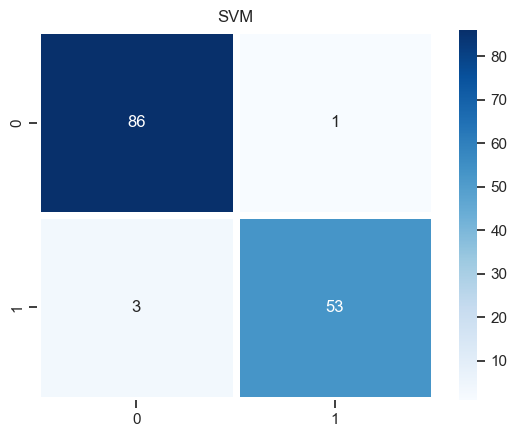

In [74]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

svm = SVC(kernel='rbf', C=80).fit(scaler.transform(X_train), y_train)

results = results.append(test_model(svm, 'SVM', scaler), ignore_index=True)
draw_confusion_matrix(svm, 'SVM', scaler)


XGB Model se ne pojavljuje u paperu ali je nadodan jer smo ga spomenuli na prvom sastanku za projekt.

In [75]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

results = results.append(test_model(xgb_model, 'XGB'), ignore_index=True)


[18:40:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Algorith XGB: Training accuracy=1.0, Testing accuracy=0.965034965034965



C:\ProgramData\Anaconda3\envs\DataScienceProject\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Tablica rezultata.

In [76]:
results

,Algorithms,Training Accuracy,Testing Accuracy
0,Logistic regression,99.30%,93.01%
1,KNN,95.31%,90.91%
2,Decision Tree,100.00%,93.71%
3,Naive Bayes,93.90%,93.71%
4,Random Forest,100.00%,95.80%
5,SVM,100.00%,97.20%
6,XGB,100.00%,96.50%
